In [1]:
%load_ext autoreload
%autoreload 2

%matplotlib notebook

import logging
logging.basicConfig()

from pathlib import Path
from pprint import pprint

from tqdm import tqdm, trange

import numpy as np
import matplotlib.pyplot as plt
import cv2 as cv

import fish

In [2]:
NOTEBOOK_NAME = "_template"

HERE = Path.cwd().absolute()
DATA = HERE.parent / "data"
OUT = HERE / "out" / Path(NOTEBOOK_NAME).stem
print(HERE)
print(DATA)
print(OUT)

D:\projects\fish\dev
D:\projects\fish\data
D:\projects\fish\dev\out\_template


In [3]:
frames = fish.cached_read(DATA / "D1-1.hsv")

DEBUG:fish.io:Cached read from D:\projects\fish\data\D1-1.hsv.cached


In [4]:
flow = cv.calcOpticalFlowFarneback(
    frames[100], frames[101], None, 
    pyr_scale = 0.5,
    levels = 3,
    winsize = 11,
    iterations = 5,
    poly_n = 5,
    poly_sigma = 1.1,
    flags = cv.OPTFLOW_FARNEBACK_GAUSSIAN,
)

<ipython-input-5-00facae56b75>:8: UserWarning: tight_layout : falling back to Agg renderer
  fig.tight_layout()


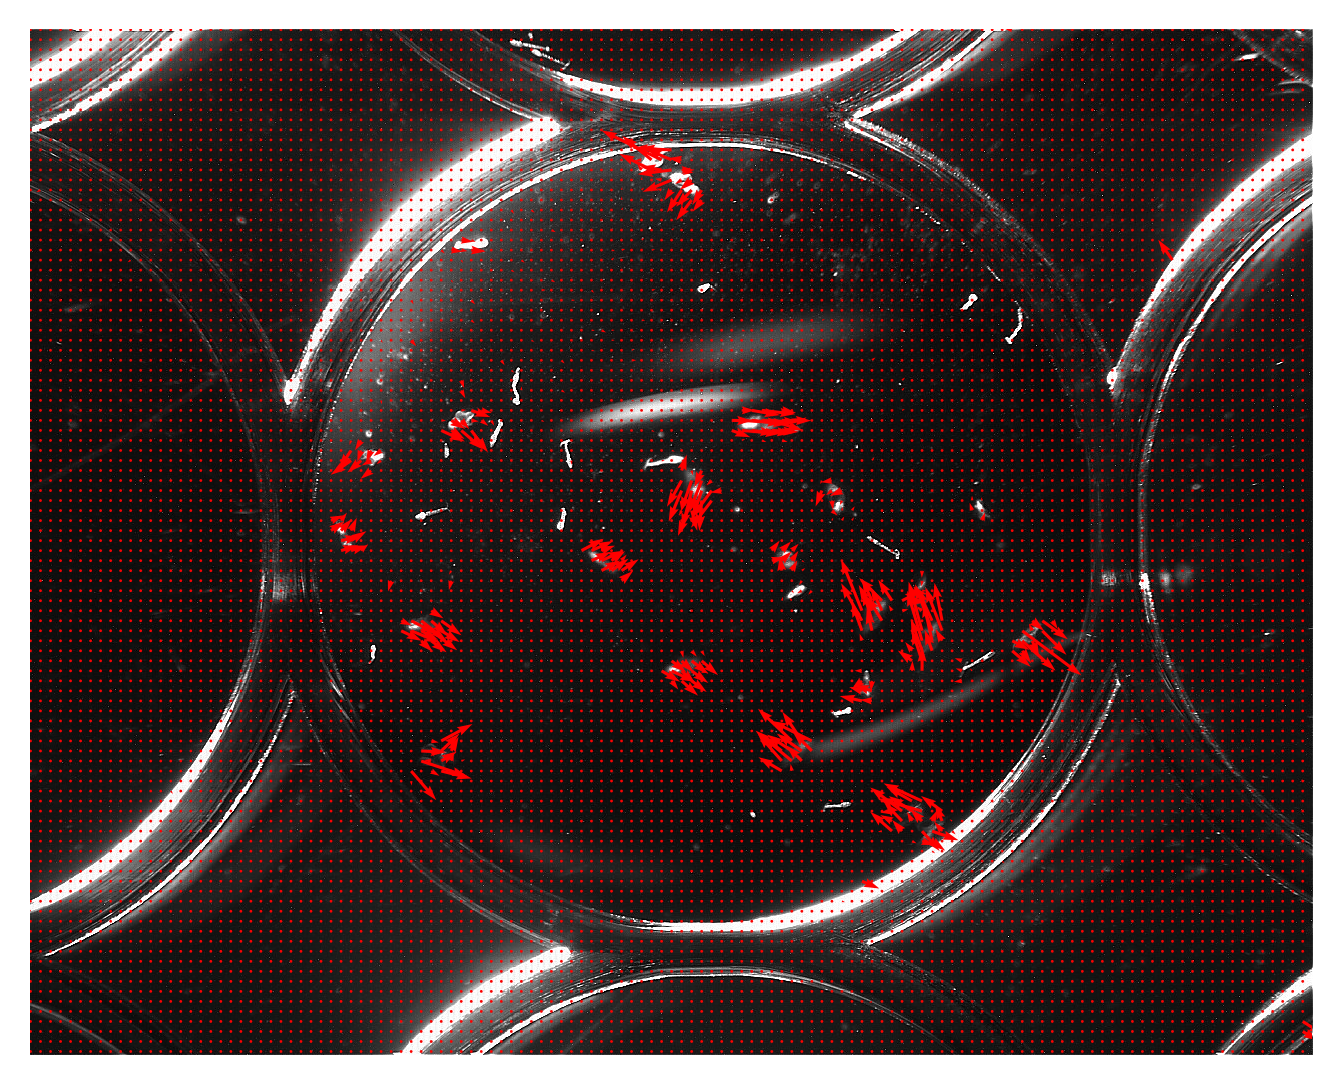

In [5]:
fig = plt.Figure(figsize = (6,4), dpi = 300)
ax = fig.add_subplot(111)

ax.imshow(frames[100], cmap="gray", vmin=0, vmax=255)
ax.quiver(np.arange(1280)[::10], np.arange(1024)[::10], flow[::10, ::10, 0], flow[::10, ::10, 1], 
          color = 'red', scale = 400, pivot = 'tail')

fig.tight_layout()
ax.axis('off')

fig

In [6]:
velocity_norm = np.linalg.norm(flow, axis = -1)
velocity_norm_image = (velocity_norm * 255 / np.max(velocity_norm)).astype(np.uint8)

(1024, 1280)


d:\projects\fish\fish\figs.py:25: UserWarning: tight_layout : falling back to Agg renderer
  fig.tight_layout()


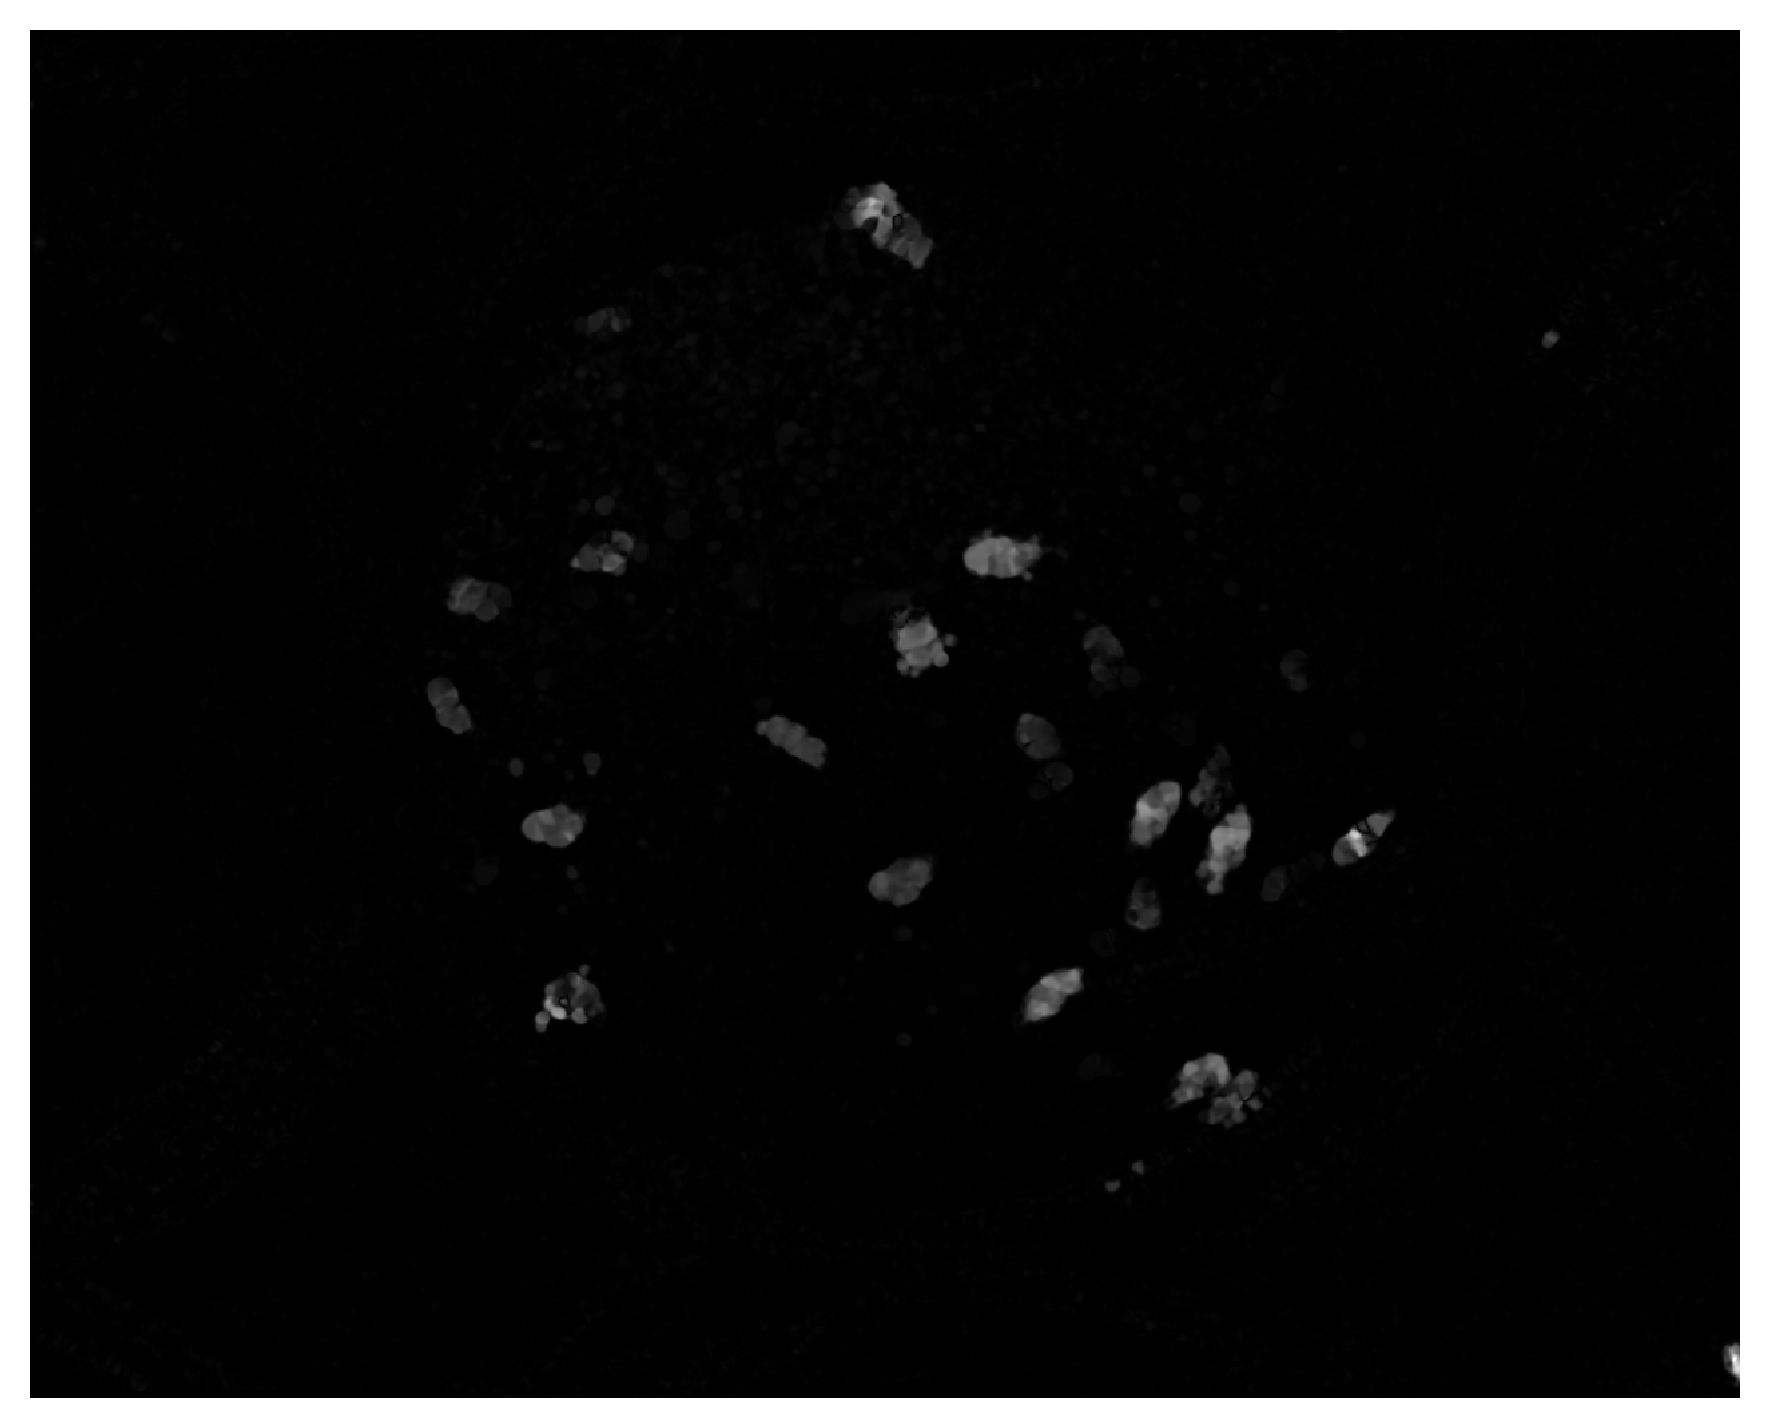

In [7]:
print(velocity_norm.shape)
fish.show_frame(velocity_norm * 255 / np.max(velocity_norm))

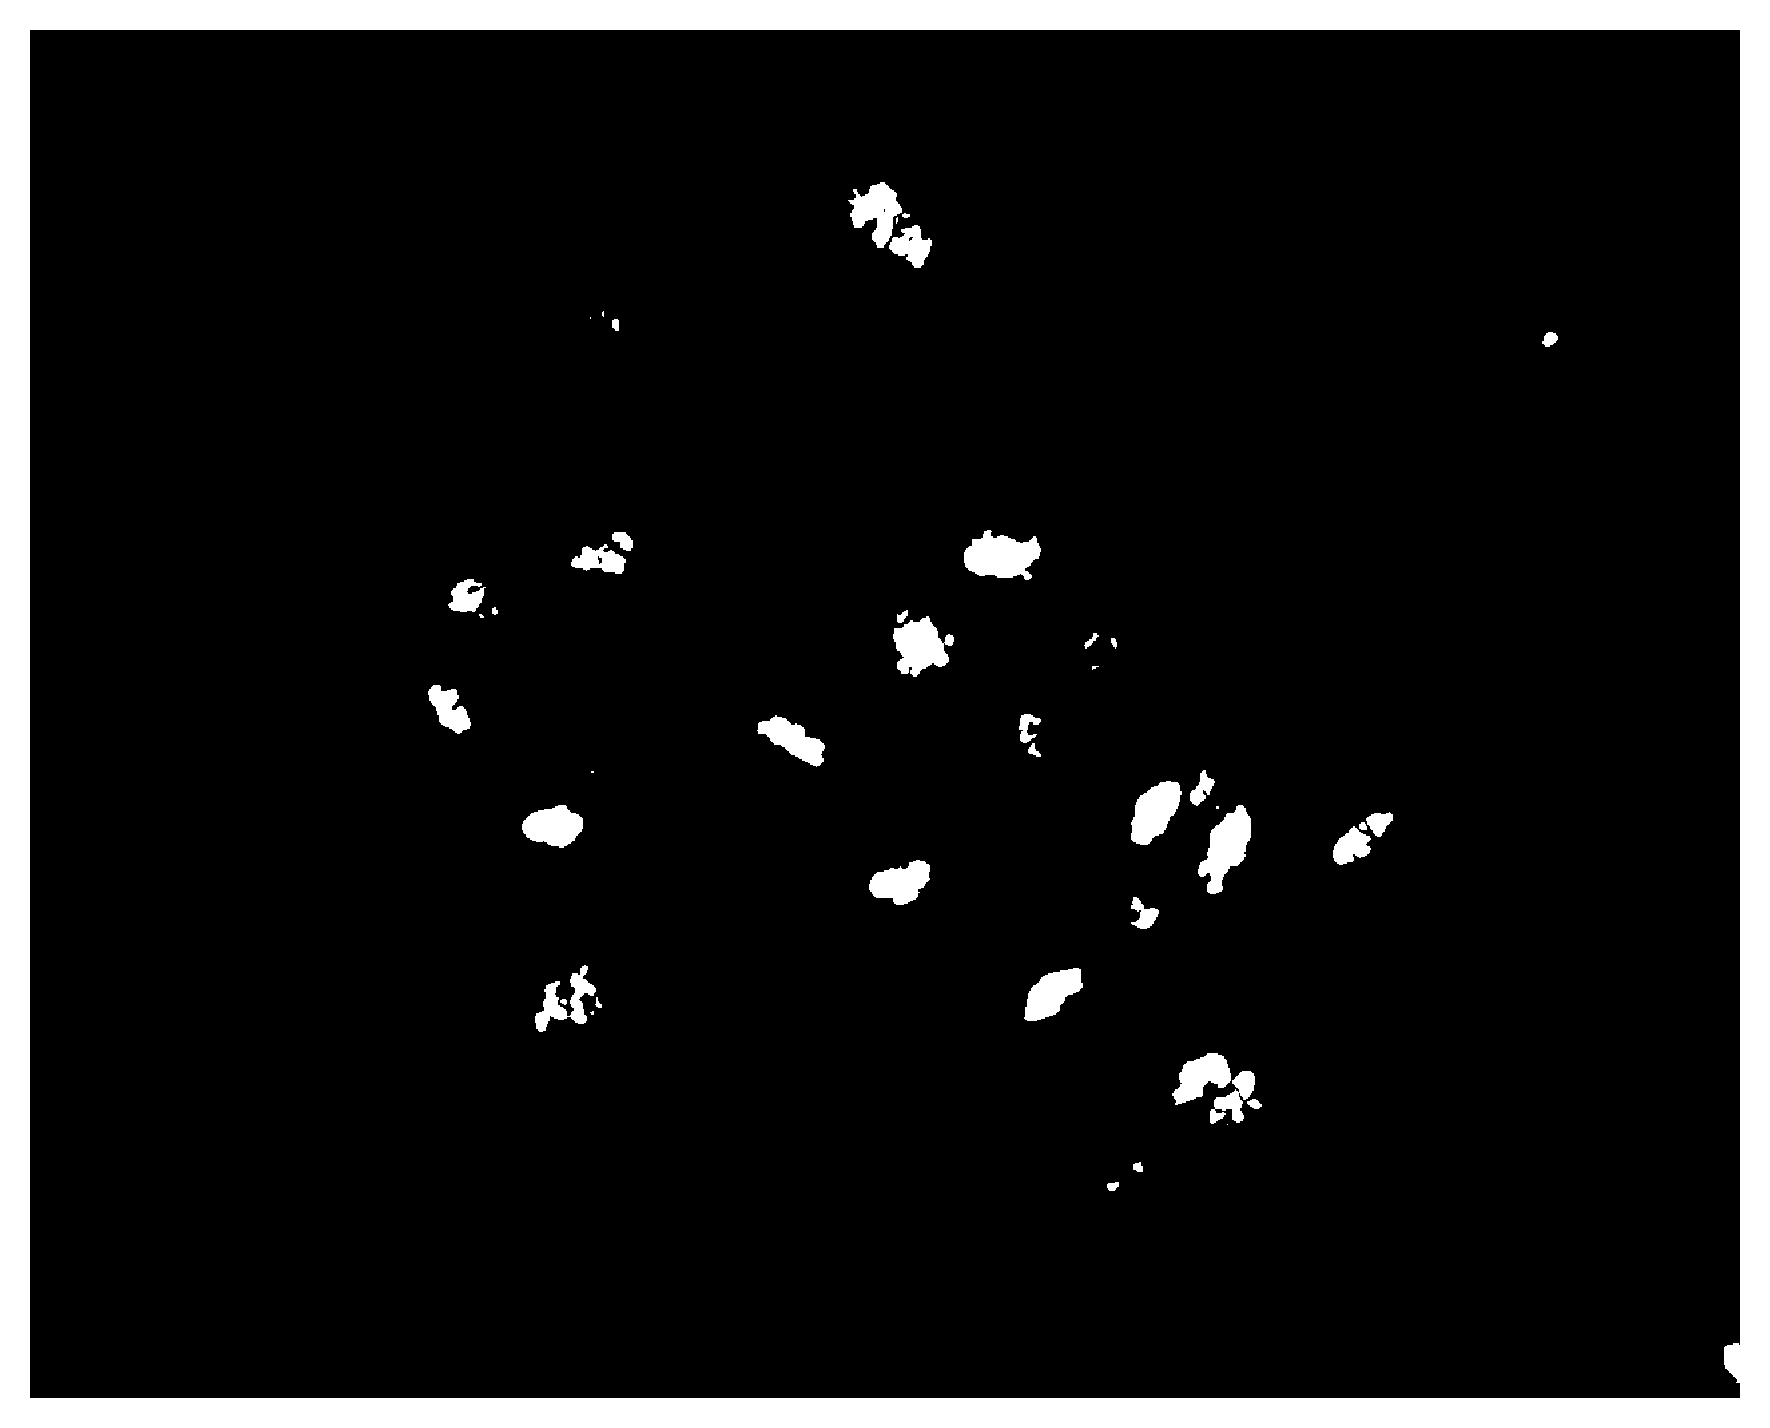

In [8]:
thresh, thresholded = cv.threshold(
    velocity_norm_image, thresh=0, maxval=255, type=cv.THRESH_OTSU
)
fish.show_frame(thresholded)

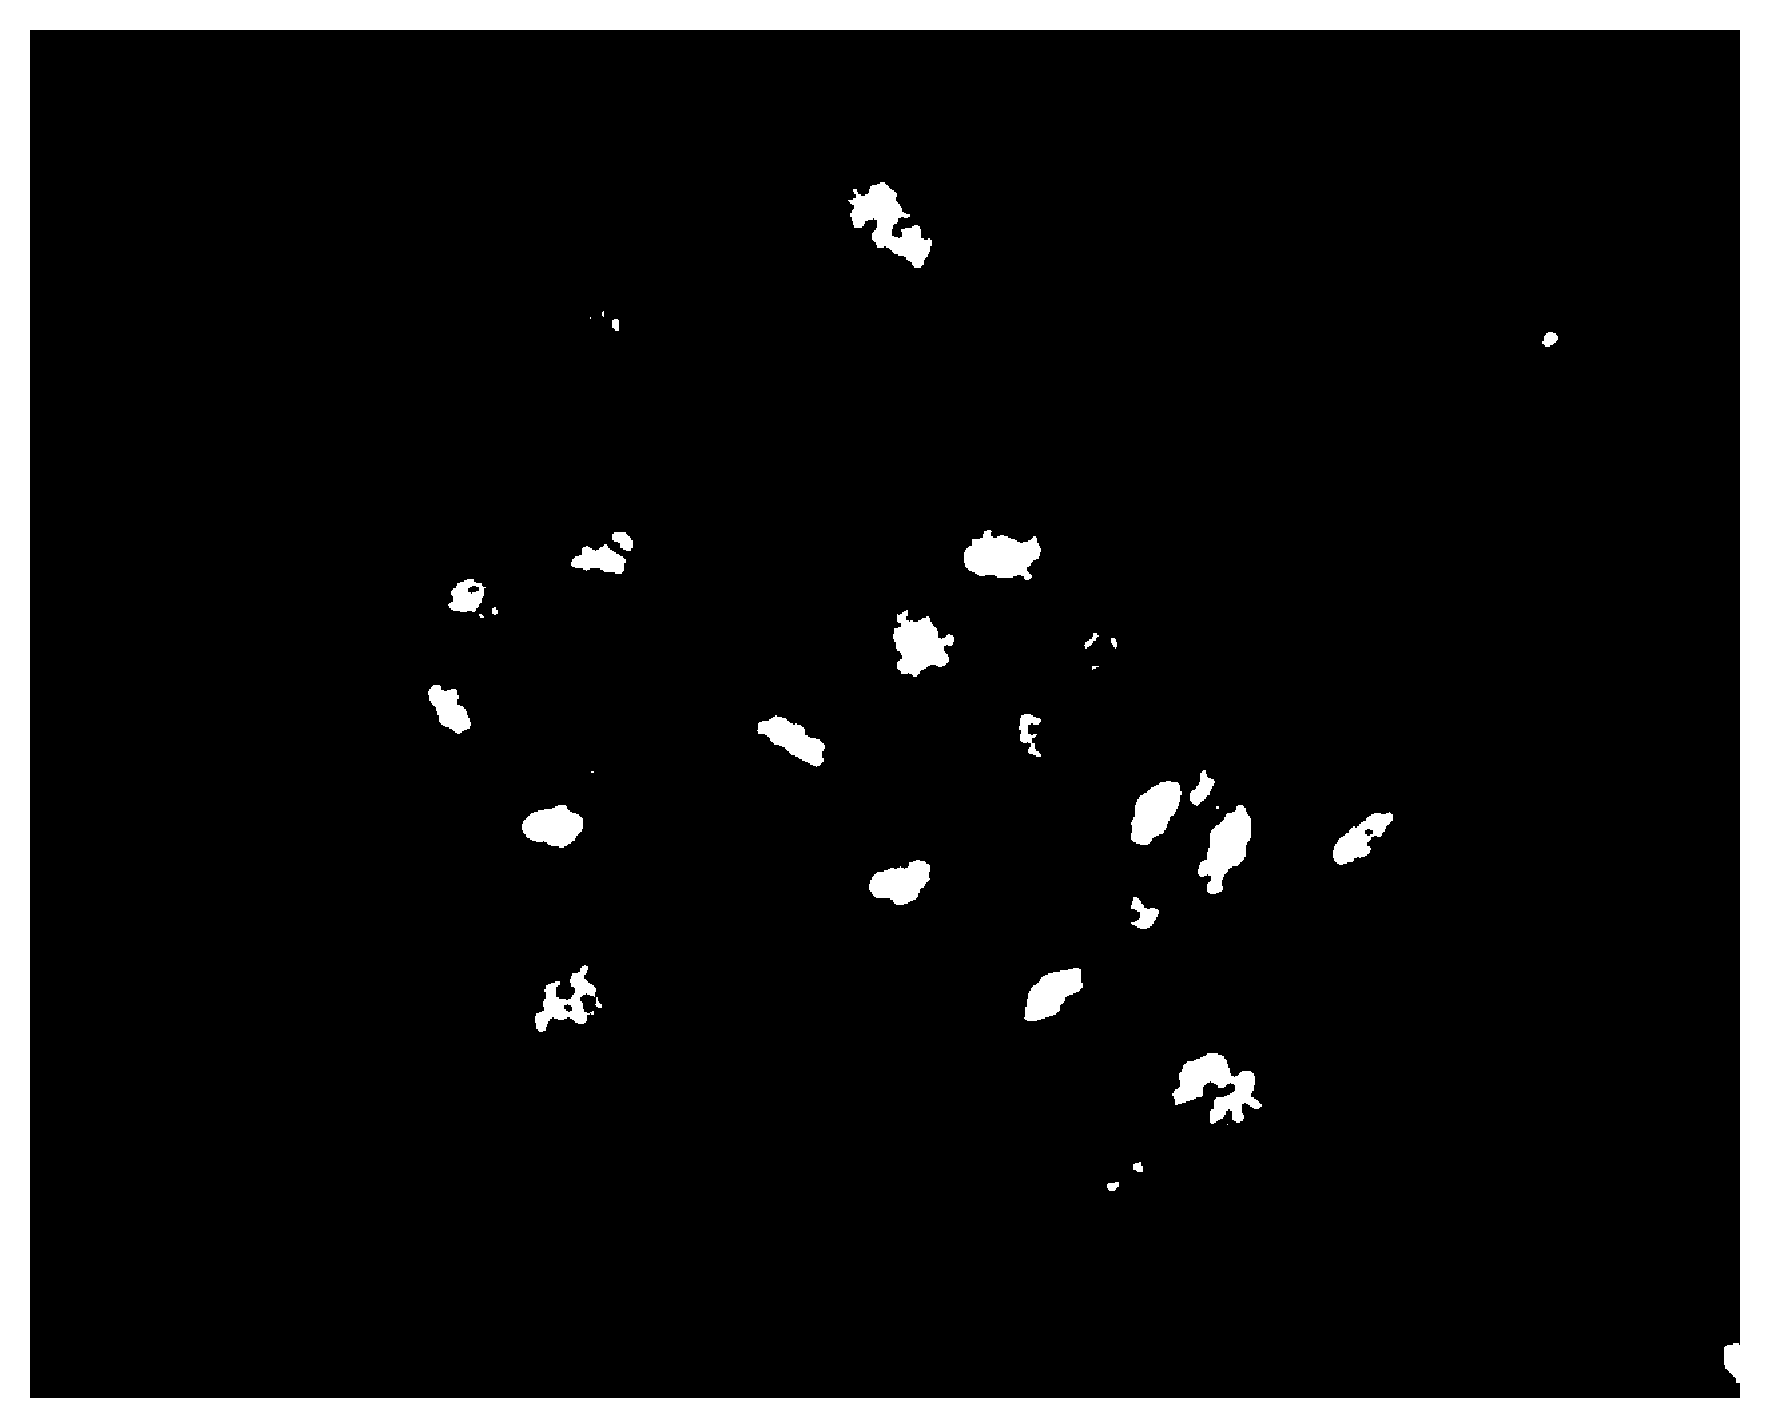

In [9]:
KERNEL_SIZE = 5
KERNEL = cv.getStructuringElement(
    cv.MORPH_ELLIPSE, (KERNEL_SIZE, KERNEL_SIZE)
)
closed_thresholded = cv.morphologyEx(thresholded, cv.MORPH_CLOSE, KERNEL)

fish.show_frame(closed_thresholded)

In [10]:
num_labels, labels, stats, _ = cv.connectedComponentsWithStats(closed_thresholded, 8)

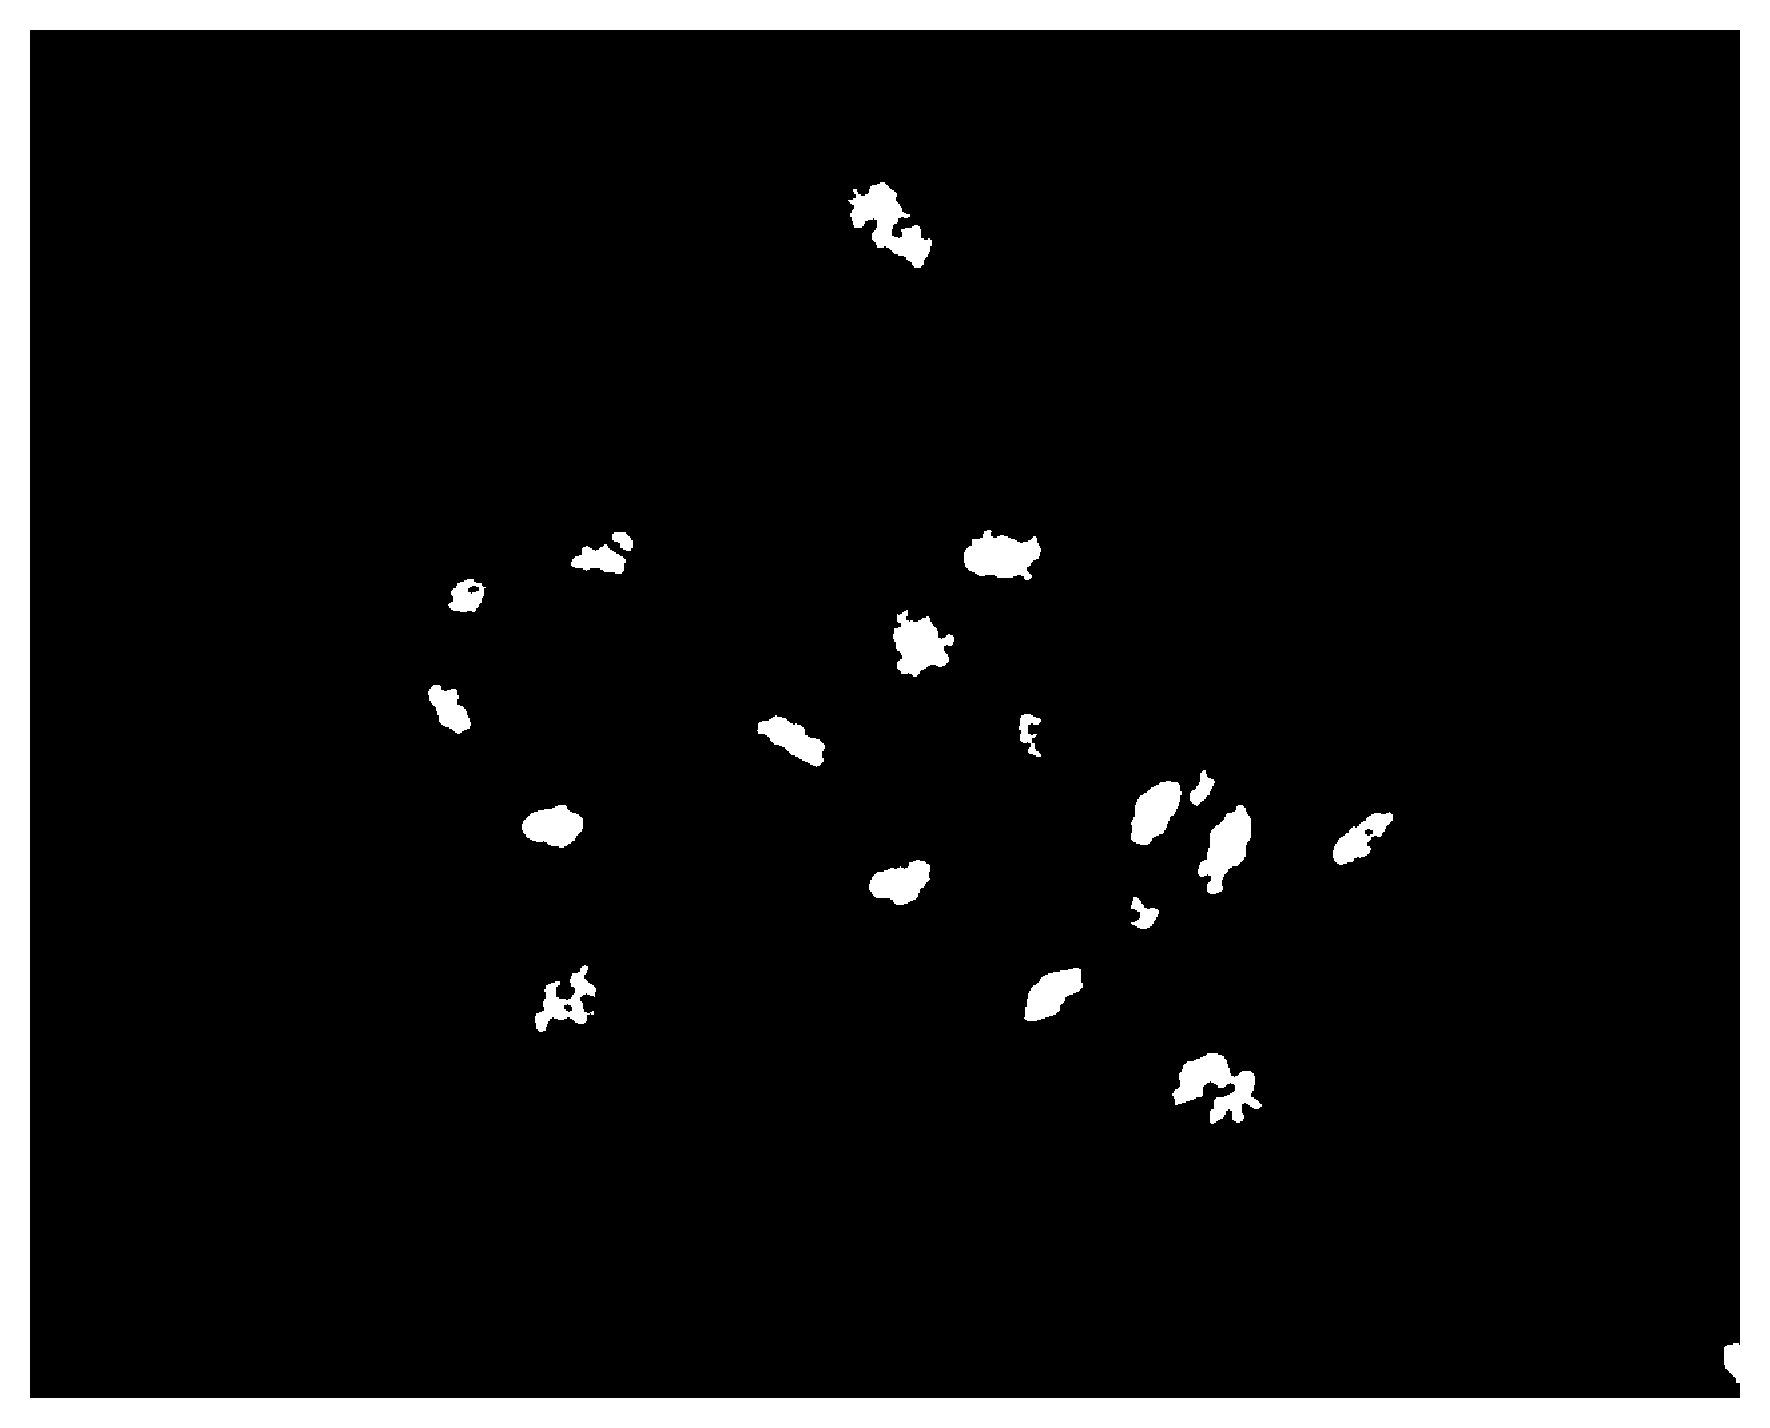

In [11]:
mask = np.zeros_like(labels)
label_areas = {}
for label in range(num_labels):
    area = stats[label, cv.CC_STAT_AREA]
    if 100 < area < 10_000:
        mask[labels == label] = 255
        label_areas[label] = area

fish.show_frame(mask)

In [12]:
label_areas

{1: 1763,
 6: 1473,
 7: 144,
 8: 576,
 9: 455,
 11: 1361,
 16: 674,
 17: 950,
 18: 258,
 20: 250,
 21: 1172,
 22: 1037,
 24: 1413,
 25: 831,
 26: 1017,
 27: 268,
 28: 962,
 29: 1058,
 31: 1743,
 35: 275}

In [13]:
label_avg_velocity = {}
for label in label_areas:
    velocity_in_label = fish.apply_mask(velocity_norm, labels == label)
    label_avg_velocity[label] = np.mean(velocity_in_label)
    
label_avg_velocity

{1: 0.011395191,
 6: 0.011037088,
 7: 0.00063331524,
 8: 0.0027680665,
 9: 0.0019868712,
 11: 0.009092629,
 16: 0.0027581875,
 17: 0.004655425,
 18: 0.0009980071,
 20: 0.0010987093,
 21: 0.008770172,
 22: 0.0060489313,
 24: 0.011156691,
 25: 0.0057449853,
 26: 0.004851645,
 27: 0.0010881738,
 28: 0.005831242,
 29: 0.008361807,
 31: 0.010462705,
 35: 0.0029180392}

In [14]:
avg_velocity = np.mean(list(label_avg_velocity.values()))
print(avg_velocity)

0.005582894


In [15]:
KERNEL_SIZE = 5
KERNEL = cv.getStructuringElement(
    cv.MORPH_ELLIPSE, (KERNEL_SIZE, KERNEL_SIZE)
)

def flow_from_frames(frames):
    prev_flow = None
    for frame_idx, frame in tqdm(enumerate(frames[:-1]), desc = "Calculating average velocity of objects...", total = len(frames)):
        next_frame = frames[frame_idx + 1]
        
        flow = fish.optical_flow(frame, next_frame, prev_flow = prev_flow)
        
        flow_norm = np.linalg.norm(flow, axis = -1)
        flow_norm_image = (flow_norm * 255 / np.max(flow_norm)).astype(np.uint8)
        
        thresh, thresholded = cv.threshold(
            flow_norm_image, thresh=0, maxval=255, type=cv.THRESH_OTSU
        )
        
        closed_thresholded = cv.morphologyEx(thresholded, cv.MORPH_CLOSE, KERNEL)
        
        num_labels, labels, stats, _ = cv.connectedComponentsWithStats(closed_thresholded, 8)
        
        label_areas = {}
        for label in range(num_labels):
            area = stats[label, cv.CC_STAT_AREA]
            if 100 < area < 10_000:
                label_areas[label] = area
        
        for label, area in label_areas.items():
            velocity_in_label = fish.apply_mask(flow_norm, labels == label)
            label_avg_velocity[label] = np.sum(velocity_in_label) / area
        
        avg_velocity = np.mean(list(label_avg_velocity.values()))
        
        yield avg_velocity

In [16]:
flows = np.array(list(flow_from_frames(frames)))
flows

Calculating average velocity of objects...: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████▉| 1815/1816 [32:12<00:01,  1.06s/it]


array([ 6.1179869 ,  7.15293307,  7.29135689, ..., 15.04168065,
       14.86324187, 14.88142041])

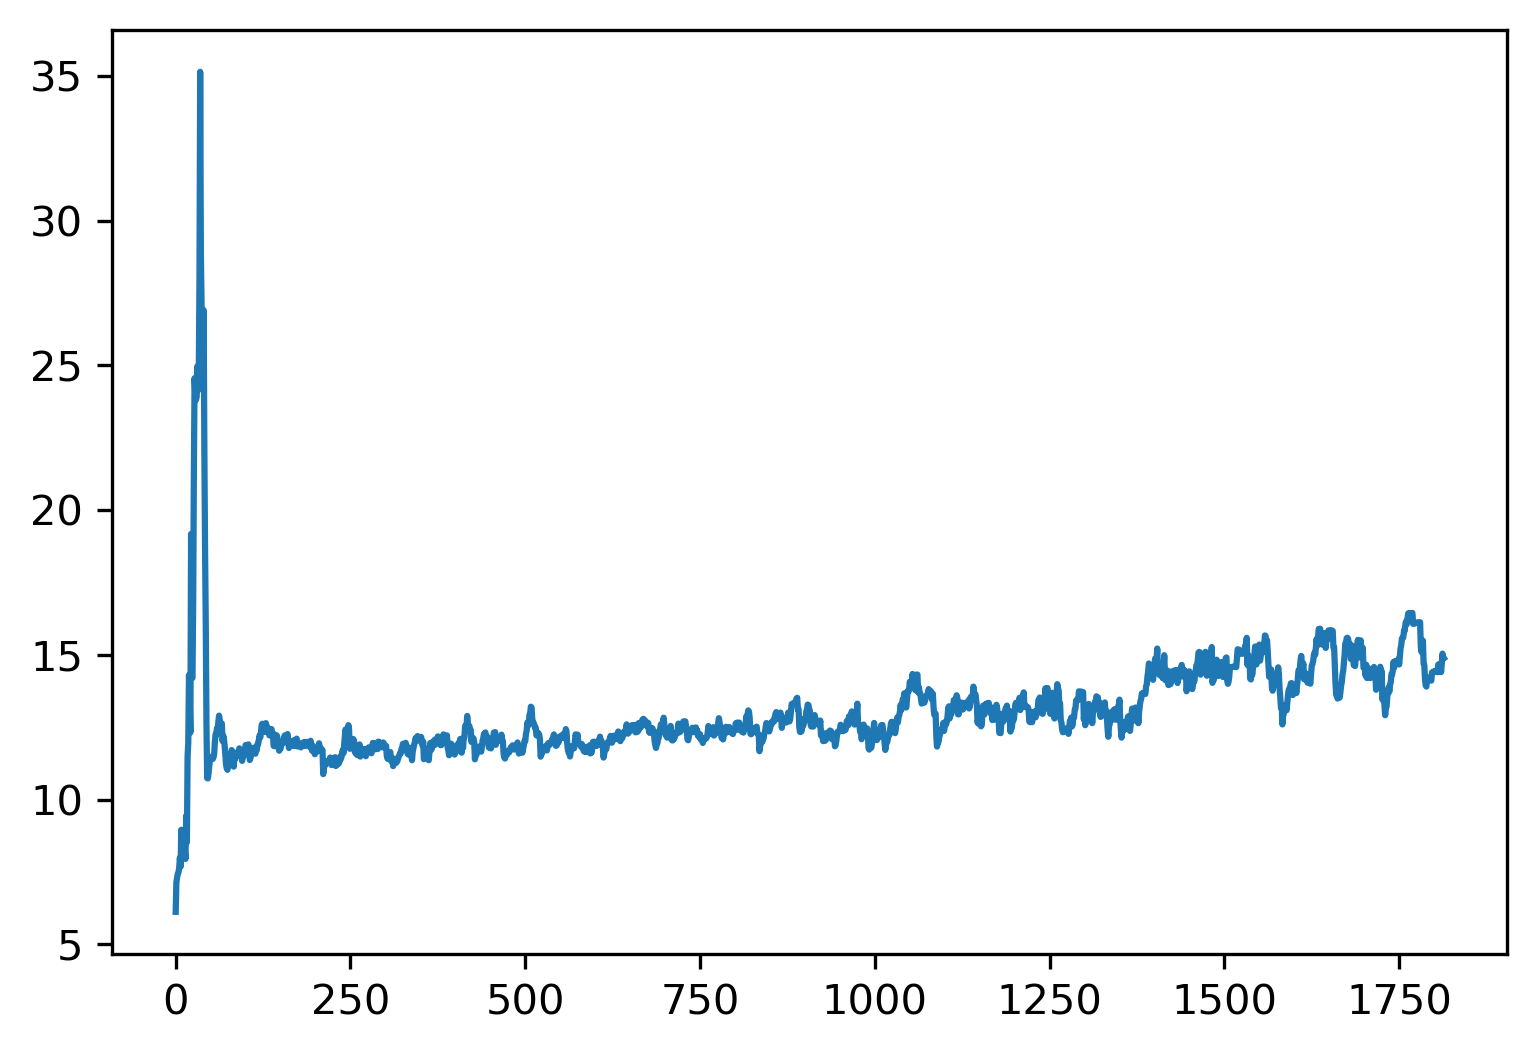

In [17]:
plt.close()
fig = plt.Figure(figsize = (6, 4), dpi = 300)
ax = fig.add_subplot(111)
ax.plot(flows)

fig